In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from luc_crime_fncs import cleaner, gps_to_merc, find_all_address
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource

In [2]:
# creating a sample DF of chicago crime dataset

originalPath = 'C:/Users/agarc/CrimeAnalyses/ChicagoCrime/DataSets/crimes_2022.csv'
starting_df = pd.read_csv(originalPath)

# n = 500
# starting_df = sampleDF(originalPath, n)

starting_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12766270,JF323407,07/17/2022 12:30:00 PM,039XX W 62ND ST,0820,THEFT,$500 AND UNDER,RESIDENCE - YARD (FRONT / BACK),False,False,...,23.0,65,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
1,12765091,JF321809,07/17/2022 11:15:00 AM,001XX W MADISON ST,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32,14,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
2,12766260,JF323206,07/17/2022 07:08:00 PM,032XX W BELMONT AVE,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,False,False,...,35.0,21,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
3,12763575,JF320436,07/17/2022 03:46:00 AM,0000X W CONGRESS PKWY,0820,THEFT,$500 AND UNDER,GAS STATION,False,False,...,4.0,32,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
4,12767451,JF324492,07/17/2022 05:00:00 PM,014XX S SACRAMENTO DR,0820,THEFT,$500 AND UNDER,PARK PROPERTY,False,False,...,24.0,29,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN


In [3]:
# cleaning up column names; updates starting_df
cleaner(starting_df, lower=True, dropna=True)

# removes speficied columns
main_df = starting_df.drop(columns=['id', 'case_number', 'iucr', 'location_description', 'arrest',
                             'domestic', 'ward', 'fbi_code', 'x_coordinate', 'y_coordinate',
                             'beat', 'district', 'community_area', 'year', 'updated_on', 
                             'latitude', 'longitude']) 
main_df.head()

print('main_df length:', len(main_df))

print(len(main_df['location'].value_counts())) # checking if mulitple crimes occur in at coords

main_df length: 150389
84155


In [4]:
# passing location val to gps_to_merc and populating new col with returned val
# anonymous fnc is needed as apply() only takes fncs invoked w/out parentheses

main_df['xCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[0])
main_df['yCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[1])
print(len(main_df))
main_df.head()

150389


,date,block,primary_type,description,location,xCoords,yCoords
5,07/14/2022 11:00:00 PM,002XX E RANDOLPH ST,CRIMINAL DAMAGE,TO VEHICLE,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06
6,06/20/2022 06:30:00 PM,068XX N SEELEY AVE,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,"(42.005679058, -87.681913036)",-9.760706e+06,5.161830e+06
7,01/21/2022 09:30:00 PM,080XX S ESSEX AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,"(41.749253201, -87.563762808)",-9.747553e+06,5.123492e+06
8,01/27/2022 09:10:00 PM,012XX W 87TH ST,ASSAULT,SIMPLE,"(41.73590915, -87.655034981)",-9.757714e+06,5.121502e+06
9,01/27/2022 04:00:00 PM,041XX W MADISON ST,THEFT,OVER $500,"(41.88068906, -87.728733158)",-9.765918e+06,5.143124e+06


In [5]:
# groups data by (location, primary_type, description) values and applies count fnc
crime_freq_by_coords = main_df.groupby(['location', 'primary_type', 'description']).count().reset_index()

# drop columns to avoid duplicate cols after merger in the next cell 
crime_freq_by_coords.drop(columns=['date', 
                                   'block', 
                                   'yCoords'], inplace=True)

# renames col for clairity
crime_freq_by_coords.rename(columns={'xCoords':'crime_freq'}, inplace=True)
print('crime_freq_by_coords length:', len(crime_freq_by_coords))
print('crime_freq sum:',crime_freq_by_coords['crime_freq'].sum())
crime_freq_by_coords.head()

crime_freq_by_coords length: 128731
crime_freq sum: 150389


,location,primary_type,description,crime_freq
0,"(41.644595158, -87.596781458)",BATTERY,DOMESTIC BATTERY SIMPLE,1
1,"(41.644608279, -87.613581972)",ROBBERY,AGGRAVATED VEHICULAR HIJACKING,1
2,"(41.644612024, -87.601570479)",THEFT,OVER $500,1
3,"(41.645287658, -87.540012254)",MOTOR VEHICLE THEFT,AUTOMOBILE,1
4,"(41.645287658, -87.540012254)",OTHER OFFENSE,TELEPHONE THREAT,1


In [6]:
# inner merge crime_freq_by_coords and main_df together on location column
crime_freq_df = pd.merge(main_df, crime_freq_by_coords, on=['location', 'primary_type', 'description'], how='inner')
crime_freq_df.drop_duplicates(subset=['location', 'primary_type', 'description'], inplace=True)
print('crime_freq_df length:', len(crime_freq_df))
print('crime_freq sum:', crime_freq_df['crime_freq'].sum())
crime_freq_df.head()

crime_freq_df length: 128731
crime_freq sum: 150389


False

In [7]:
# assigning glyph size based on crime_freq; if freq <= 17, then size is freq + 3;
# if freq > 17, then size is 30
glyph_sizes = [freq + 3 if freq <= 17 else 30 for freq in crime_freq_df['crime_freq']]

# make new df for map
for_bokeh_df = crime_freq_df.copy()

for_bokeh_df['glyph_size'] = glyph_sizes # new col for glyph sizes
for_bokeh_df.head()

,date,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size
0,07/14/2022 11:00:00 PM,002XX E RANDOLPH ST,CRIMINAL DAMAGE,TO VEHICLE,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4
1,06/20/2022 06:30:00 PM,068XX N SEELEY AVE,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,"(42.005679058, -87.681913036)",-9.760706e+06,5.161830e+06,1,4
2,01/21/2022 09:30:00 PM,080XX S ESSEX AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,"(41.749253201, -87.563762808)",-9.747553e+06,5.123492e+06,1,4
3,01/27/2022 09:10:00 PM,012XX W 87TH ST,ASSAULT,SIMPLE,"(41.73590915, -87.655034981)",-9.757714e+06,5.121502e+06,1,4
4,01/27/2022 04:00:00 PM,041XX W MADISON ST,THEFT,OVER $500,"(41.88068906, -87.728733158)",-9.765918e+06,5.143124e+06,1,4


In [8]:
# north/south bound streets with home number between 56XX to 72XX
northStreets = ['N KENMORE AVE', 'N WINTHROP AVE', 'N ARTHUR AVE', 'N SHERIDAN RD', 
                'N LAKEWOOD AVE', 'N MAGNOLIA AVE', 'N GLENWOOD AVE', 'N NEWGARD AVE'
                'N GREENVIEW AVE', 'N BOSWORTH AVE', 'N ASHLAND AVE', 'N CLARK ST',
                'N RAVENSWOOD AVE', 'N RIDGE AVE', 'N RIDGE BLVD', 'N WOLCOTT AVE', 
                'N WAYNE AVE', 'N BROADWAY', 'N PAULINA ST', 'N HERMITAGE AVE', 
                'N DAMEN']

# west/east bound streets with home number less than or equal to 19XX
westStreets = ['W LOYOLA AVE', 'W SHERIDAN RD', 'W ROSEMONT AVE', 'W GRANVILLE AVE',
               'W ALBION AVE', 'W NORTH SHORE AVE', 'NEIL HARTIGAN AVE', 'W COLUMBIA AVE', 
               'W PRATT BLVD', 'W FARWELL AVE', 'W MORSE AVE', 'W LUNT AVE', 
               'W GREENLEAF AVE', 'W ESTES AVE', 'W TOUHY AVE', 'W CHASE AVE', 
               'W GLENLAKE AVE', 'W THORNDALE AVE', 'W ARDMORE AVE', 'W HOLLYWOOD AVE',
               'W BRYN MAWR AVE', 'W VICTORIA ST', 'W EARLY AVE', 'W OLIVE AVE',
               'W DEVON AVE', 'W HIGHLAND AVE', 'W THOME AVE', 'W SCHREIBER', 
               'W WALLEN AVE', 'W HOOD AVE', 'W NORWOOD AVE']

# list of addresses around LUC where crimes occurred
luc_addresses = find_all_address(crime_freq_df, addressCol='block', horiSt=westStreets, vertSt=northStreets)

# makes DF of bool values indicating whether a luc_addresses item is in a given cell
bool_df = for_bokeh_df.isin(luc_addresses)

# adds new column, is_by_luc to for_bokeh_df_copy
for_bokeh_df['is_by_luc'] = bool_df['block']

# makes new DF, luc_crime_df, which contains only rows that have True as value for is_by_luc

for_bokeh_df = for_bokeh_df[for_bokeh_df['is_by_luc'] == True]
for_bokeh_df.head()

,date,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size,is_by_luc
123,03/16/2022 10:00:00 PM,064XX N DAMEN AVE,THEFT,OVER $500,"(41.998589094, -87.68016062)",-9.760511e+06,5.160768e+06,1,4,True
425,03/24/2022 01:28:00 PM,016XX W GREENLEAF AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,1,4,True
504,03/07/2022 03:00:00 PM,057XX N WINTHROP AVE,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,"(41.986107062, -87.658094107)",-9.758054e+06,5.158899e+06,1,4,True
593,04/06/2022 12:00:00 AM,065XX N ASHLAND AVE,CRIMINAL DAMAGE,TO PROPERTY,"(42.000800221, -87.670465853)",-9.759432e+06,5.161099e+06,2,5,True
728,04/03/2022 07:20:00 AM,061XX N BROADWAY,THEFT,RETAIL THEFT,"(41.993043969, -87.660360363)",-9.758307e+06,5.159938e+06,27,30,True


In [9]:
# used to pass into bokeh ColumnDataSource class which contains
# map's structure parameters including coords and glyph properties
cds_dict = {'xAxis':list(for_bokeh_df['xCoords']), 
            'yAxis':list(for_bokeh_df['yCoords']), 
            'PrimaryDescription':list(for_bokeh_df['primary_type']),
            'SecondaryDescription':list(for_bokeh_df['description']),
            'Freq':list(for_bokeh_df['crime_freq']), 
            'Date':list(for_bokeh_df['date']), 
            'circleSize':list(for_bokeh_df['glyph_size']), 
            'Location':list(for_bokeh_df['location']), 
            'Block':list(for_bokeh_df['block'])}

# instantiating bokeh class
source = ColumnDataSource(data=cds_dict)

# this is how to choose the info that is displayed when hovering over glyph
hoverTool = [('Crime Type', '@PrimaryDescription'), ('Specific Type', '@SecondaryDescription'), 
             ('Frequency', '@Freq' ), ('Date/Time', '@Date'), 
             ('Block', '@Block'), ('-----------','')]

# generates Bokeh Figure
p = figure(x_axis_type = 'mercator', y_axis_type = 'mercator', tooltips=hoverTool)

# retrieves an instance of a tile provider
map_provider = get_provider(Vendors.CARTODBPOSITRON)

# adds the chosen tile provider to the plot.
p.add_tile(map_provider)

# creates glyphs on the plot and is used for customizing them
p.circle(x='xAxis', y='yAxis', source=source, 
         size='circleSize', fill_alpha= 0.20, 
         line_color='red', fill_color='red')

output_notebook()
show(p)

Loading BokehJS ...

In [19]:
# makes df with crime type frequency
crime_count_df = for_bokeh_df['primary_type'].value_counts().reset_index(name='frequency')
crime_count_df.head()

,index,frequency
0,THEFT,538
1,BATTERY,382
2,CRIMINAL DAMAGE,244
3,ASSAULT,200
4,DECEPTIVE PRACTICE,173


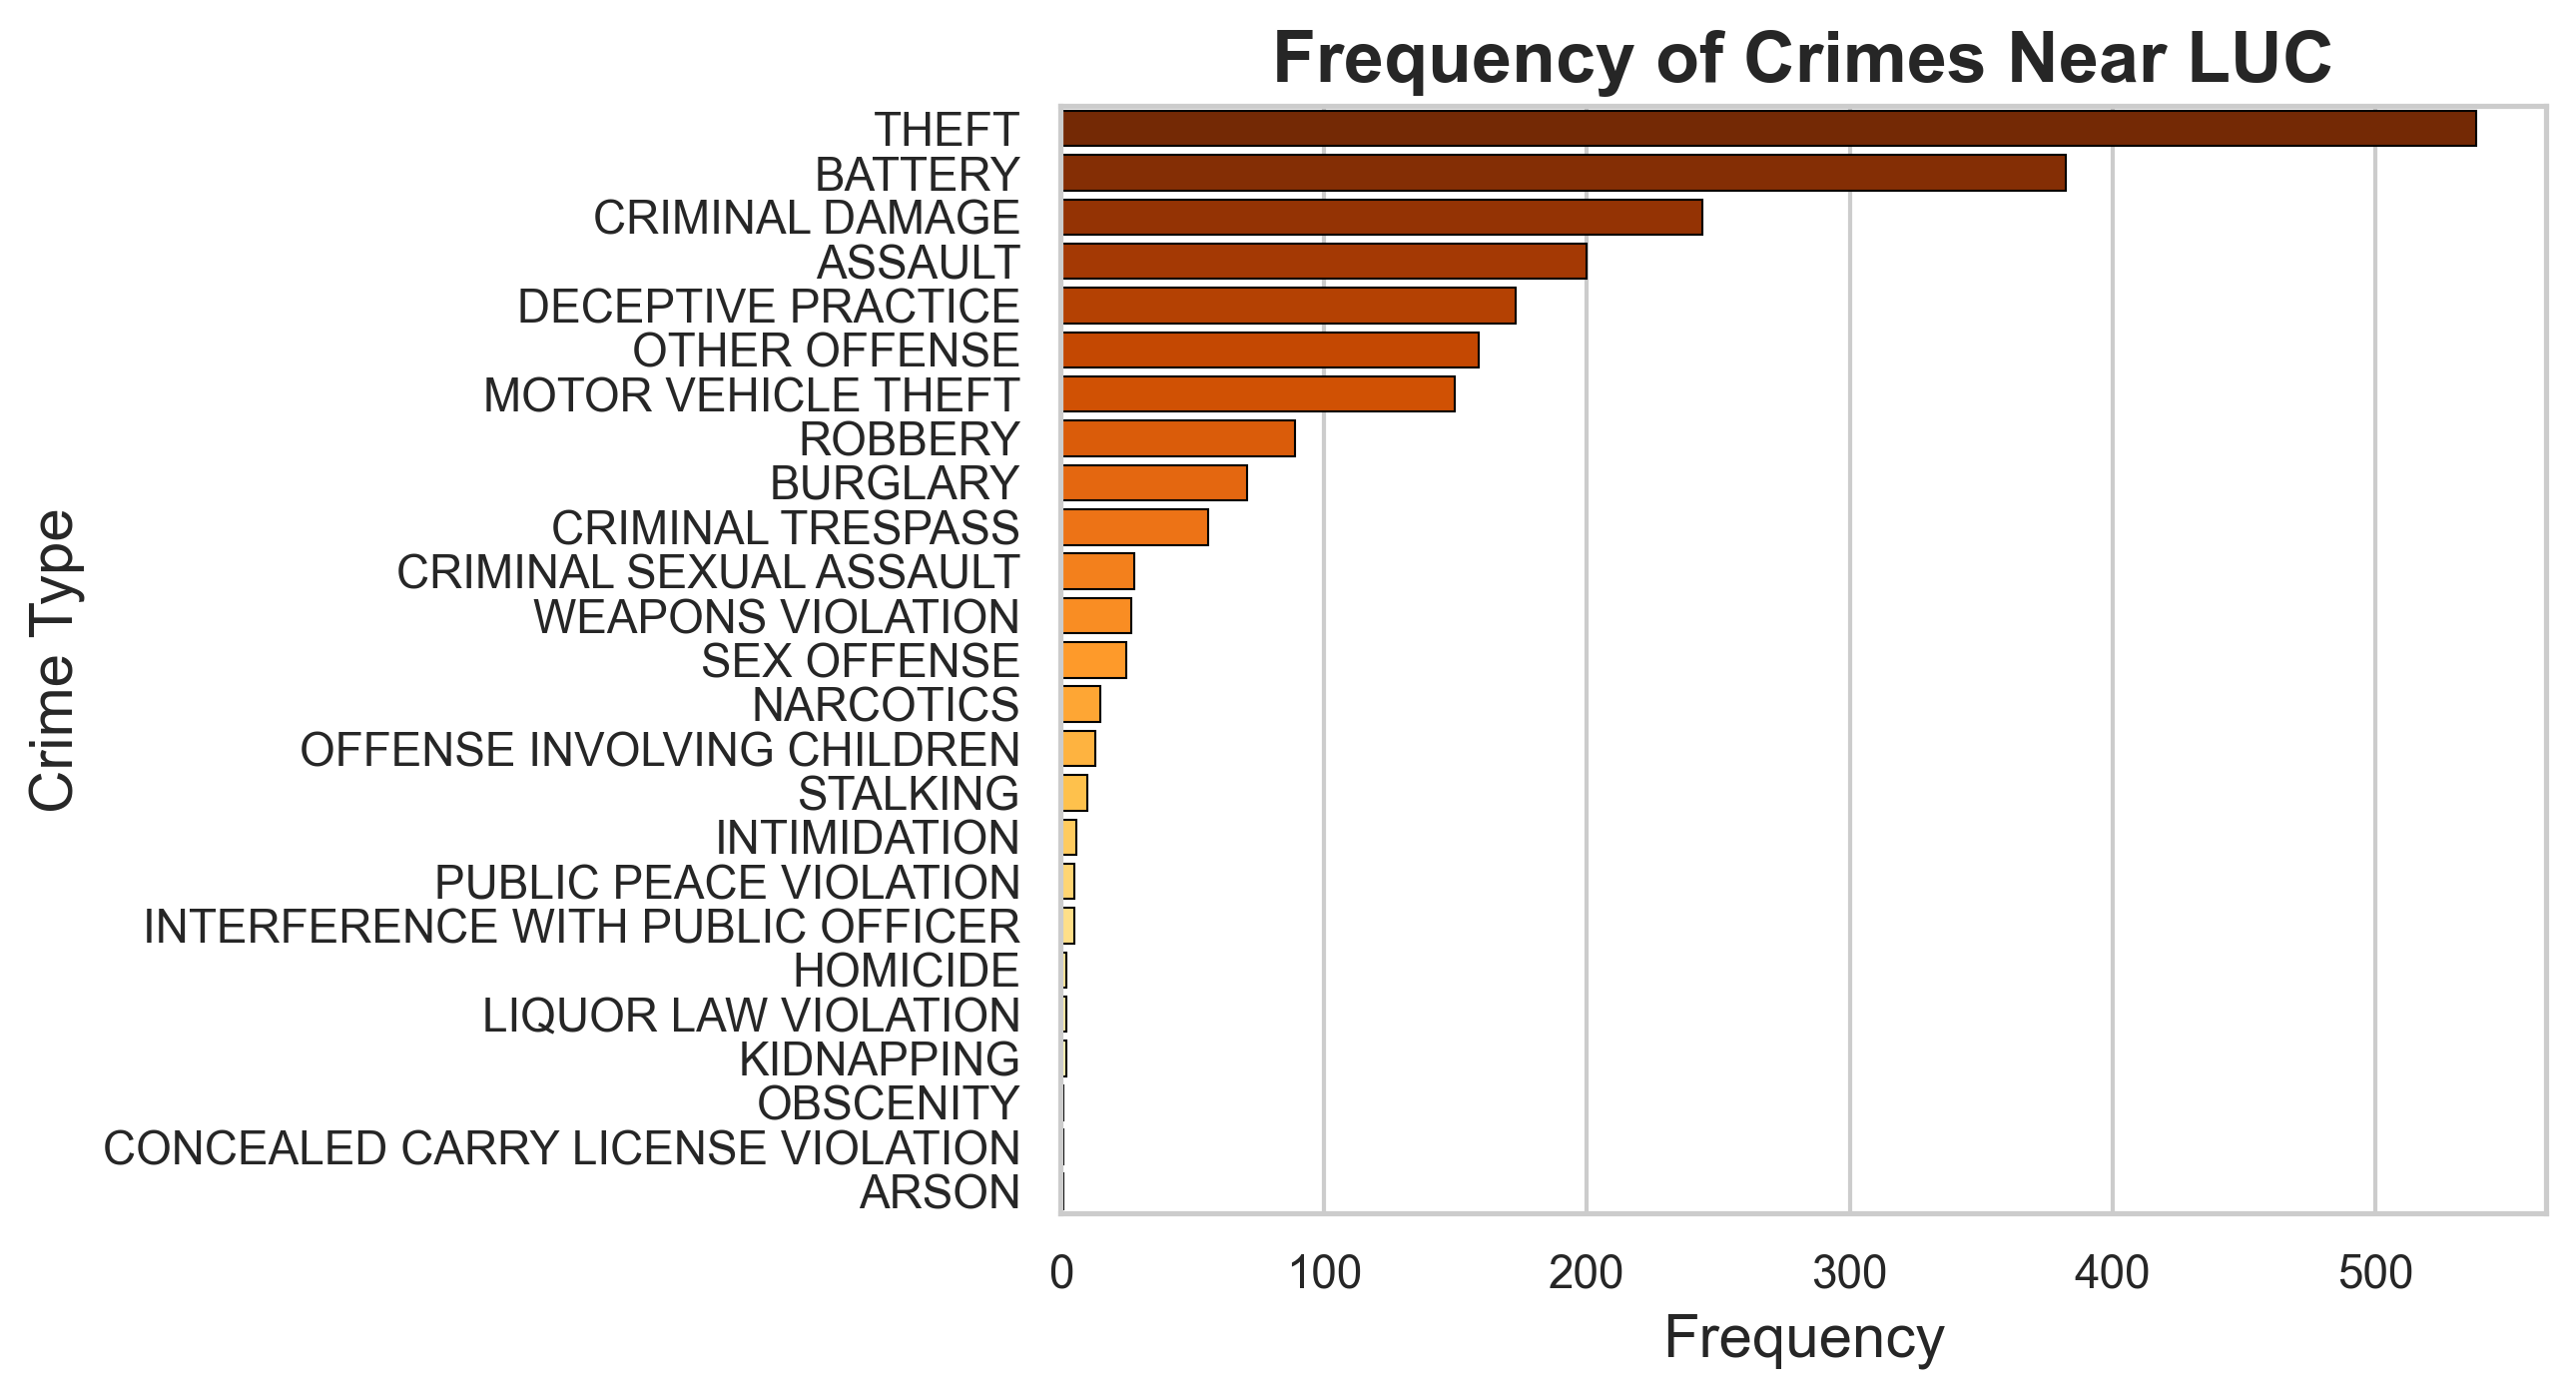

In [22]:
# sets background of graph
sns.set_theme(style='whitegrid', palette='pastel')

# creates default bar graph based on given arguments
bar_graph = sns.barplot(y='index', x='frequency', data=crime_count_df, 
                        edgecolor='black', linewidth=.5, saturation=4,
                        palette='YlOrBr_r')

# following 3 lines change the axes names adds title
bar_graph.set_xlabel('Frequency', size='large')
bar_graph.set_ylabel('Crime', size='large')
bar_graph.set_title('Frequency of Crimes Near LUC', weight='bold', size='x-large') # make bold and x-large

# increases resolution of graph
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.show()